<a href="https://colab.research.google.com/github/bratzaharia/ml-data-science-1/blob/main/07_01_Detectivul_de_date_si_regresia_liniara_diamante_bratc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diamante - clean data ols si gradient descent

> Add blockquote



Problemele tratate - exemple!
Nu există valori lipsă (NaN) — toate coloanele sunt complet populate.
Tipurile de date sunt coerente: numerice și categorice clare.
Nu sunt duplicate (fiecare diamant are combinație unică de caracteristici).
Categorii bine definite:
cut: Fair, Good, Very Good, Premium, Ideal
color: J, I, H, G, F, E, D
clarity: I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF

In [ ]:
# 📦 Importuri
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import copy


pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

## 1) Încărcare date

In [ ]:
# încărcare

path = f"https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"

df_raw = pd.read_csv(path)
df_raw.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2) Diagnoză inițială

Ne uităm la forme, tipuri de date, lipsuri și distribuții rapide.

In [ ]:
print("(linii, coloane):", df_raw.shape)
df_raw.info()

(linii, coloane): (53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
df_raw.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
# Verificat valori null
df_raw.isnull().sum().value_counts(dropna=False).head(20)

,count
0,10


In [ ]:
# Verificare valori duplicate:
df_raw.duplicated().sum()
df_raw[df_raw.duplicated()].head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
2183,1.00,Fair,E,SI2,67.0,53.0,3136,6.19,6.13,4.13
2820,1.00,Fair,F,SI2,65.1,55.0,3265,6.26,6.23,4.07
3156,0.90,Very Good,I,VS2,58.4,62.0,3334,6.29,6.35,3.69
3704,1.00,Ideal,E,SI2,62.9,56.0,3450,6.32,6.30,3.97
3981,1.00,Fair,H,SI1,65.5,57.0,3511,6.26,6.21,4.08


In [ ]:
# verifi daca in col numerice exista nr negative
num_cols = df_raw.select_dtypes(include='number').columns
(df_raw[num_cols] < 0).sum()



,0
carat,0
depth,0
table,0
price,0
x,0
y,0
z,0


In [ ]:
# Elimina duplicatele:
df_raw = df_raw.drop_duplicates(keep='first')
df_raw.head(10)
# df.duplicated().sum()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [ ]:
# procent de lipsuri
missing_percent = df_raw.isnull().mean() * 100

print("\nProcent valori lipsă (%):")
print(missing_percent.sort_values(ascending=False))


Procent valori lipsă (%):
carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
price      0.0
x          0.0
y          0.0
z          0.0
dtype: float64


### Observații așteptate
Avem o problema la dimensiuni - 1. uneori x, y sau z sunt 0 ceea ce este imposibil pt un diamant real  SI 2 duplicate -  rezolvat 3 nu avem valori null

## 3) Plan de curățare (rezumat)
 **Doar valoril 0 trebuie verificate si rezolvate**

## 4) Regresia liniara pt diamante

In [ ]:
df = df_raw.copy()

:### 4.1) `x, y sau z` →

In [ ]:
# afiseaza doar x, y, z
# (df[['x', 'y', 'z']] <= 0).sum()
# vezi randuri problematice
df[(df['x'] <= 0) | (df['y'] <= 0) | (df['z'] <= 0)]

# din afisare rezulkta ca z il voi sterge
# valorile de la x + y care sunt 0 => imputam cu mediana

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [ ]:
# Cat la % sunt gresite
invalid_rows = df[(df['x'] <= 0) | (df['y'] <= 0) | (df['z'] <= 0)]
print(f"Rânduri invalide: {len(invalid_rows)} din {len(df)} ({len(invalid_rows)/len(df)*100:.2f}%)")


Rânduri invalide: 19 din 53794 (0.04%)


### 4.2) Tratare lipsuri
- `x` → imputăm cu **mediană** (robust la outlieri)
- `y` → imputăm cu **mediană** (robust la outlieri)
z il sterg

In [ ]:
x_mediana = df["x"].median()
y_mediana = df["y"].median()
z_mediana = df["z"].median()

df.loc[df["x"] <= 0, "x"] = x_mediana
df.loc[df["y"] <= 0, "y"] = y_mediana
df.loc[df["z"] <= 0, "z"] = z_mediana

invalid_rows = df[(df['x'] <= 0) | (df['y'] <= 0) | (df['z'] <= 0)]
print(f"Rânduri invalide: {len(invalid_rows)} din {len(df)} ({len(invalid_rows)/len(df)*100:.2f}%)")



Rânduri invalide: 0 din 53794 (0.00%)


### 4.3) Eliminare valori invalide / negative
verific daca avem valori neg sau 0

In [ ]:
num_cols = df.select_dtypes(include='number').columns;
(df[num_cols] < 0).sum()

,0
carat,0
depth,0
table,0
price,0
x,0
y,0
z,0


\### 4.4) Standardizare `nume diamant` dupa exemplu
- strip spații, lowercase, apoi map la **Cluj / București / Timișoara** cu diacritice.

In [ ]:
# def normalize_city(s):
#     if pd.isna(s):
#         return np.nan
#     s = str(s).strip().lower()
#     # normalizări simple
#     s = s.replace("ș", "s").replace("ţ", "t").replace("ț", "t").replace("ă", "a").replace("â", "a").replace("î", "i")
#     mapping = {
#         "cluj": "Cluj",
#         "cluj-napoca": "Cluj",
#         "bucuresti": "București",
#         "bucuresti sector 1": "București",
#         "bucuresti sector 2": "București",
#         "timisoara": "Timișoara",
#         "timişoara": "Timișoara",
#         "": np.nan,
#         "na": np.nan,
#         "none": np.nan
#     }
#     # eliminăm spații în plus
#     s = s.strip()
#     return mapping.get(s, "Cluj" if "cluj" in s else ("București" if "bucurest" in s else ("Timișoara" if "timisoar" in s else np.nan)))

# df["oraș"] = df["oraș"].apply(normalize_city)
# df["oraș"].value_counts(dropna=False)

### 4.5) Standardizare `gen`
- Mapează toate variantele la `F` sau `M`.  
- Altele (gol, `None`, `NA`) → NaN (opțional: imputare / excludere ulterior).

In [ ]:
# # 1. Convertim valorile în string
# df["gen_clean"] = df["gen"].astype(str)

# # 2. Eliminăm spațiile de la început și sfârșit
# df["gen_clean"] = df["gen_clean"].str.strip()

# # 3. Transformăm în litere mici
# df["gen_clean"] = df["gen_clean"].str.lower()

# # 4. Mapăm valorile la "F" sau "M"
# gender_map = {
#     "f": "F", "fem": "F", "femeie": "F", "feminin": "F", "feminină": "F",
#     "m": "M", "masculin": "M", "barbat": "M", "bărbat": "M"
# }
# df["gen"] = df["gen_clean"].map(gender_map)

## 5) Verificare finală

In [ ]:
print("Forma după curățare:", df.shape)
display(df.info())
display(df.describe())

Forma după curățare: (53794, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


None

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731956,5.735290,3.539960
std,0.47339,1.429909,2.233679,3988.114460,1.118786,1.139601,0.701893
min,0.20000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
# Comparație scurtă pe categorice
for col in ["color", "cut", "clarity"]:
    print(f"\n=== {col} (după curățare) ===")
    print(df[col].value_counts(dropna=False).head(20))


=== color (după curățare) ===
color
G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: count, dtype: int64

=== cut (după curățare) ===
cut
Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: count, dtype: int64

=== clarity (după curățare) ===
clarity
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: count, dtype: int64


---

### Rezumat (ce am făcut și de ce)
- Am **diagnosticat**: lipsuri, valori negative sau 0.  
- Am **imputat**: la x, y si z mediana la valorile 0.  



In [ ]:
print(df.describe())

**REGRESIA LINIARA**

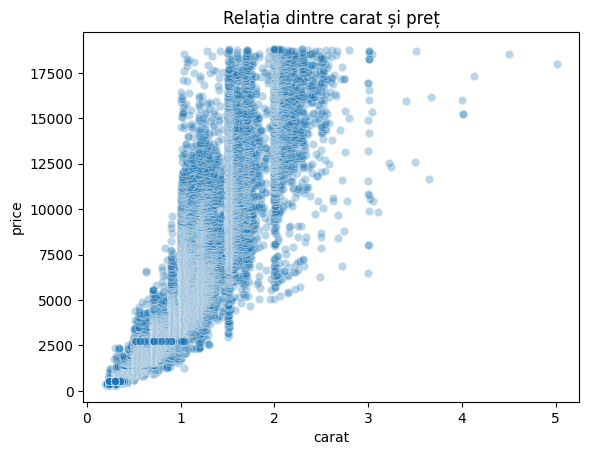

In [ ]:
# un exemplu simplu
sns.scatterplot(data=df, x='carat', y='price', alpha=0.3)
plt.title('Relația dintre carat și preț')
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


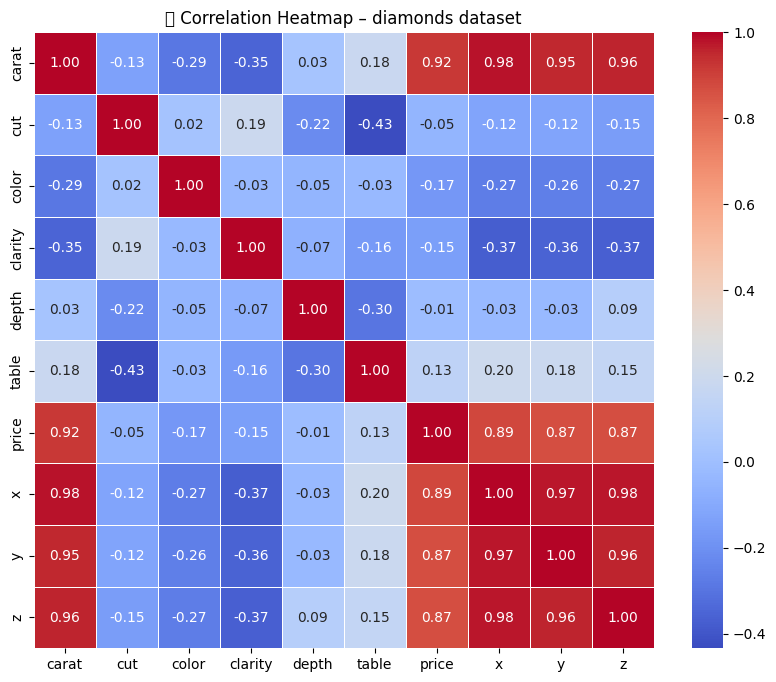

In [ ]:
# heatmap pe diamante dataset
cut_order = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
color_order = {'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}
clarity_order = {'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}

df['cut'] = df['cut'].map(cut_order)
df['color'] = df['color'].map(color_order)
df['clarity'] = df['clarity'].map(clarity_order)

# Matricea de corelație
corr = df.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("💎 Correlation Heatmap – diamonds dataset")
plt.show()

<Axes: >

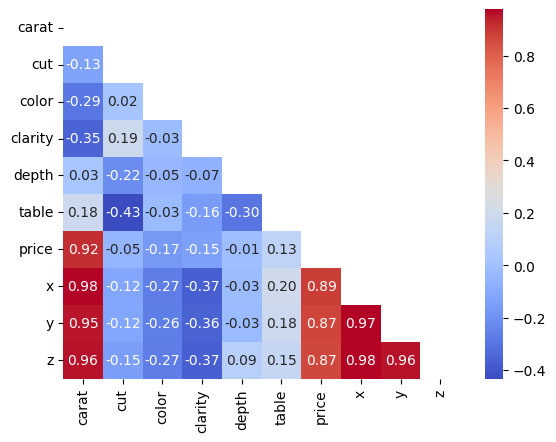

In [ ]:
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")

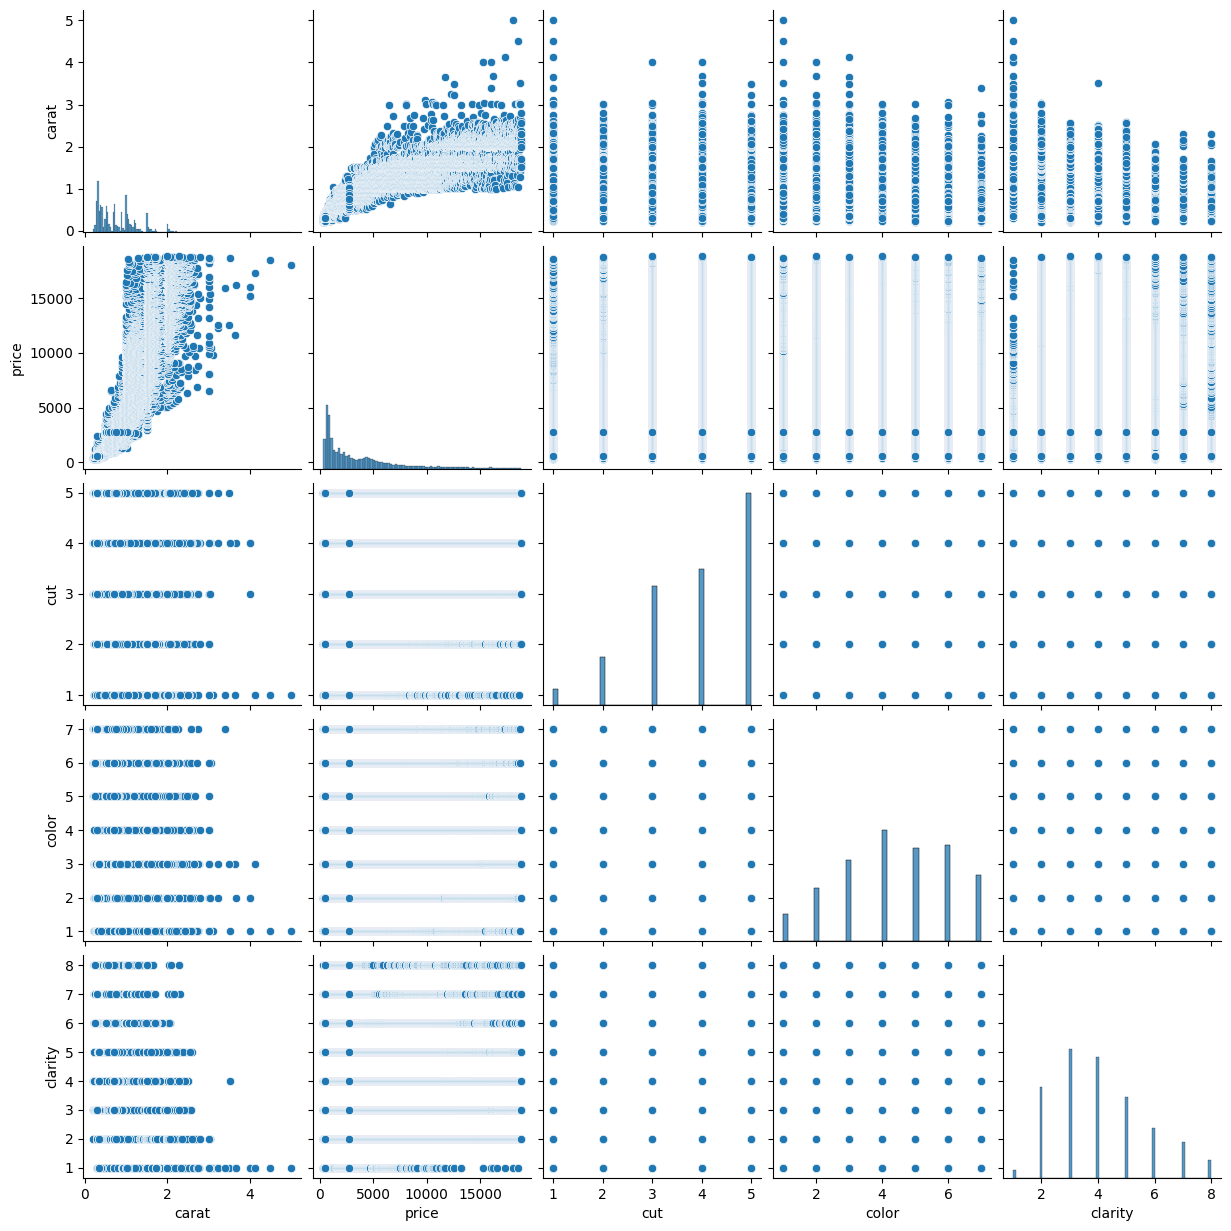

In [ ]:
sns.pairplot(df[['carat', 'price', 'cut', 'color', 'clarity']])
plt.show()

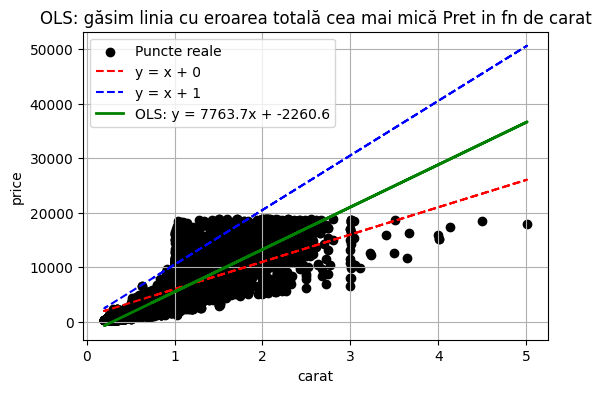

In [ ]:
# Minimizarea fn cost cu OLS
# cum creste pretul in fn de carat

# our data
x = np.array(df['carat'])
y = np.array(df['price'])

# calculeaza linia optima OLS (y=mx*n)
m = np.sum((x - x.mean()) * (y - y.mean())) / np.sum((x - x.mean()) ** 2)
n = y.mean() - m * x.mean()
y_pred_ols = m * x + n

# alte linii de test / gresite, doar pt comparatie
y_pred_1 = 5000 * x + 1000
y_pred_2 = 10000 * x + 500

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, color="black", label="Puncte reale")
plt.plot(x, y_pred_1, "--", color="red", label="y = x + 0")
plt.plot(x, y_pred_2, "--", color="blue", label="y = x + 1")
plt.plot(x, y_pred_ols, "-", color="green", linewidth=2, label=f"OLS: y = {m:.1f}x + {n:.1f}")

# Adăugăm text explicativ
plt.title("OLS: găsim linia cu eroarea totală cea mai mică Pret in fn de carat")
plt.xlabel("carat")
plt.ylabel("price")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# data preprocessing - part 2
x_train = np.array(df["carat"])
y_train = np.array(df["price"])

# for i, j in zip(x_train, y_train):
#     print(i, j)

len(x_train), len(y_train) # acelasi nr de date pe x si y!

(53794, 53794)

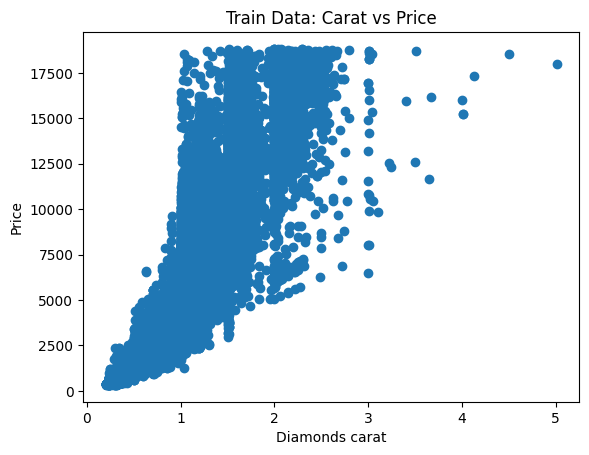

In [ ]:
plt.scatter(x_train, y_train)
plt.title("Train Data: Carat vs Price")
plt.xlabel("Diamonds carat")
plt.ylabel("Price")
plt.show()

In [ ]:
x_train.shape

def compute_cost(x, y, m, n):
    nr = x.shape[0]
    cost = 0

    for i in range(0, nr):
        f_mn = m * x[i] + n
        cost += (f_mn - y[i])**2

    total_cost = cost / (2 * nr)
    return total_cost

def compute_gradients(x, y, m, n):
  nr = x.shape[0]
  dj_dm = 0
  dj_dn = 0

  for i in range(0, nr):
      f_mn = m * x[i] + n
      dj_dm += (f_mn - y[i]) * x[i]
      dj_dn += (f_mn - y[i])

  dj_dm = dj_dm / nr
  dj_dn = dj_dn / nr

  return dj_dm, dj_dn


def gradient_descent(x, y, m_in, n_in, alpha, num_inters, cost_function, gradient_function):
    m = copy.deepcopy(m_in)
    n = copy.deepcopy(n_in)

    # cost function evolution - loss
    J_history = []

    for i in range(0, num_inters):
        dj_dm, dj_dn = gradient_function(x, y, m, n)

        m = m - alpha * dj_dm
        n = n - alpha * dj_dn

        J_history.append(cost_function(x, y, m, n))

        print(f"Iteration: {i} | Cost: {J_history[i]:.4} | dj_dm: {dj_dm:.4} | dj_dn: {dj_dn:.4} | m: {m:.4} | n: {n:.4}")

    return m, n, J_history


In [ ]:
m_init = 0
n_init = 0

iterations = 25
alpha = 0.15

# normalizare pt ca fn de cost nu functioneaza
x_norm = (x_train - x_train.mean()) / x_train.std()
y_norm = (y_train - y_train.mean()) / y_train.std()


m_final, n_final, J_history = gradient_descent(x=x_norm, y=y_norm, alpha=alpha, m_in=m_init, n_in=n_init, num_inters=iterations, cost_function=compute_cost, gradient_function=compute_gradients)
print(f"(m, n) found by gradient descent ({m_final:.4}, {n_final:.4})")

Iteration: 0 | Cost: 0.3822 | dj_dm: -0.9215 | dj_dn: -1.417e-15 | m: 0.1382 | n: 2.125e-16
Iteration: 1 | Cost: 0.297 | dj_dm: -0.7833 | dj_dn: -2.302e-15 | m: 0.2557 | n: 5.578e-16
Iteration: 2 | Cost: 0.2355 | dj_dm: -0.6658 | dj_dn: 2.388e-16 | m: 0.3556 | n: 5.22e-16
Iteration: 3 | Cost: 0.1911 | dj_dm: -0.5659 | dj_dn: 2.914e-15 | m: 0.4405 | n: 8.484e-17
Iteration: 4 | Cost: 0.159 | dj_dm: -0.4811 | dj_dn: 3.195e-15 | m: 0.5127 | n: -3.943e-16
Iteration: 5 | Cost: 0.1358 | dj_dm: -0.4089 | dj_dn: -5.375e-17 | m: 0.574 | n: -3.863e-16
Iteration: 6 | Cost: 0.119 | dj_dm: -0.3476 | dj_dn: 1.66e-15 | m: 0.6261 | n: -6.352e-16
Iteration: 7 | Cost: 0.1069 | dj_dm: -0.2954 | dj_dn: 7.057e-16 | m: 0.6704 | n: -7.411e-16
Iteration: 8 | Cost: 0.09815 | dj_dm: -0.2511 | dj_dn: -1.609e-15 | m: 0.7081 | n: -4.997e-16
Iteration: 9 | Cost: 0.09183 | dj_dm: -0.2134 | dj_dn: -7.871e-16 | m: 0.7401 | n: -3.816e-16
Iteration: 10 | Cost: 0.08727 | dj_dm: -0.1814 | dj_dn: 4.748e-16 | m: 0.7673 | n: 

In [ ]:
J_history

[np.float64(0.3821663809205451),
 np.float64(0.2970315911356507),
 np.float64(0.23552170551605459),
 np.float64(0.1910808131558984),
 np.float64(0.15897226842568957),
 np.float64(0.13577384485811267),
 np.float64(0.11901298383053606),
 np.float64(0.1069032617381142),
 np.float64(0.09815398752633588),
 np.float64(0.09183263690833107),
 np.float64(0.08726546108681994),
 np.float64(0.08396567655578073),
 np.float64(0.0815815822321021),
 np.float64(0.07985907408324634),
 np.float64(0.07861456194569459),
 np.float64(0.07771540192631685),
 np.float64(0.07706575881231907),
 np.float64(0.07659639166244908),
 np.float64(0.07625727389666948),
 np.float64(0.07601226131089697),
 np.float64(0.0758352397176738),
 np.float64(0.07570734161657261),
 np.float64(0.07561493523852407),
 np.float64(0.07554817163038414),
 np.float64(0.07549993492350442)]

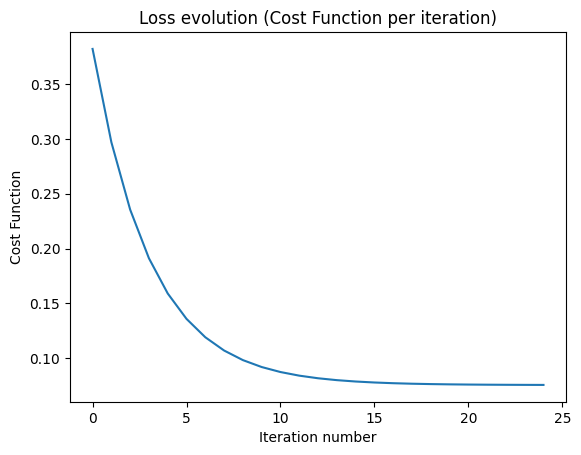

In [ ]:
plt.plot(J_history)
plt.title("Loss evolution (Cost Function per iteration)")
plt.xlabel("Iteration number")
plt.ylabel("Cost Function")
plt.show()

In [ ]:
# test alte rate de invatare
for alpha in [0.001, 0.01, 0.1, 0.5]:
    m, n, J_hist = gradient_descent(x=x_norm, y=y_norm, alpha=alpha, m_in=m_init, n_in=n_init, num_inters=iterations, cost_function=compute_cost, gradient_function=compute_gradients)
    print(f"alpha={alpha}, cost_final={J_hist[-1]:.6f}")


Iteration: 0 | Cost: 0.4992 | dj_dm: -0.9215 | dj_dn: -1.417e-15 | m: 0.0009215 | n: 1.417e-18
Iteration: 1 | Cost: 0.4983 | dj_dm: -0.9206 | dj_dn: -6.723e-15 | m: 0.001842 | n: 8.14e-18
Iteration: 2 | Cost: 0.4975 | dj_dm: -0.9197 | dj_dn: -3.82e-15 | m: 0.002762 | n: 1.196e-17
Iteration: 3 | Cost: 0.4966 | dj_dm: -0.9188 | dj_dn: -5.165e-15 | m: 0.003681 | n: 1.713e-17
Iteration: 4 | Cost: 0.4958 | dj_dm: -0.9179 | dj_dn: 2.778e-16 | m: 0.004599 | n: 1.685e-17
Iteration: 5 | Cost: 0.4949 | dj_dm: -0.9169 | dj_dn: 6.099e-15 | m: 0.005515 | n: 1.075e-17
Iteration: 6 | Cost: 0.4941 | dj_dm: -0.916 | dj_dn: -1.068e-15 | m: 0.006432 | n: 1.182e-17
Iteration: 7 | Cost: 0.4933 | dj_dm: -0.9151 | dj_dn: -3.103e-16 | m: 0.007347 | n: 1.213e-17
Iteration: 8 | Cost: 0.4924 | dj_dm: -0.9142 | dj_dn: 6.711e-15 | m: 0.008261 | n: 5.415e-18
Iteration: 9 | Cost: 0.4916 | dj_dm: -0.9133 | dj_dn: 2.099e-15 | m: 0.009174 | n: 3.316e-18
Iteration: 10 | Cost: 0.4908 | dj_dm: -0.9124 | dj_dn: -2.227e-15 

In [ ]:
def r2_score(y, y_):
    num = np.sum((y - y_)**2)
    denom = np.sum((y - y.mean())**2)

    score = 1 - num / denom
    return score

In [ ]:
y_pred_norm = [m_final * i + n_final for i in x_norm]
r2_score(y_norm, y_pred_norm) # between 0 - 1.

np.float64(0.8490001301529899)

**Predictie**

In [ ]:
# diamond_carat = ??
# print(f"A diamond with {diamond_carat} carat has a price of: {m_final * diamond_carat + n_final}$")
# daca nu de-normalizezi rezultatul e fals

# Predictie cu denormalizare
x_mean = x.mean()
x_std = x.std()
y_mean = y.mean()
y_std = y.std()

# diamant nou
diamond_carat = 3.4

# Normalizează valoarea lui x
x_norm_pred = (diamond_carat - x_mean) / x_std

# Prezicere pe scara normalizată
y_norm_pred = m_final * x_norm_pred + n_final

# De-normalizare: înapoi la scara originală (dolari)
y_pred_real = y_norm_pred * y_std + y_mean

print(f"A diamond with {diamond_carat} carat has a predicted price of: ${y_pred_real:.2f}")


A diamond with 5.4 carat has a predicted price of: $39048.65
